In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from sklearn.model_selection import train_test_split
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from pmdarima import auto_arima
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse, rmse
from datetime import date
from datetime import timedelta
from datetime import *
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from fbprophet import Prophet
from statsmodels.tsa.api import VAR
import json
import base64
import urllib
import xgboost as xgb

Importing plotly failed. Interactive plots will not work.


In [2]:
df = pd.read_csv('DailyDelhiClimateTrain.csv',
                       index_col ='date',
                       parse_dates = True)
df.head()

,humidity,wind_speed,meanpressure,meantemp
date,,,,
2013-01-01,92.000000,2.980000,1017.800000,7.400000
2013-01-02,84.500000,0.000000,1015.666667,10.000000
2013-01-03,87.000000,4.633333,1018.666667,11.000000
2013-01-04,71.333333,1.233333,1017.166667,8.666667
2013-01-05,86.833333,3.700000,1016.500000,6.000000


In [3]:
def convert_to_datetime(df):
    try:
        df['date'] = pd.to_datetime(df['date'], format='%m/%d/%Y')
    except:
        pass

    try:
        df['date'] = pd.to_datetime(df['date'], format='%Y/%m/%d')
    except:
        pass

    try:
        df['date'] = pd.to_datetime(df['date'], format='%Y/%d/%m')
    except:
        pass

    try:
        df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y')
    except:
        pass

    try:
        df['date'] = pd.to_datetime(df['date'], format='%d/%Y/%m')
    except:
        pass

    try:
        df['date'] = pd.to_datetime(df['date'], format='%m/%Y/%d')
    except:
        pass

In [4]:
def preprocess(df):
    if ((df.duplicated()).sum() > 0):
        print("There are:",(df.duplicated()).sum(), "duplicates.")
        df.drop_duplicates(inplace=True)
        
    convert_to_datetime(df)
    
    df = df.fillna(method='ffill').fillna(method='bfill')
    
    df.sort_values(by=["date"], inplace = True)
    
    return df

In [5]:
df = preprocess(df)

In [6]:
def extend_dataset(forecast_days):
    index_count = 0
    new_df = df.copy()
    for column in df.columns:
        stepwise_fit = auto_arima(df[column], start_p = 1, start_q = 1,
                              max_p = 1, max_q = 1, m = 12,
                              start_P = 0, seasonal = True,
                              d = None, D = 1, trace = True,
                              error_action ='ignore',   
                              suppress_warnings = True,  
                              stepwise = True)           

        best_params = stepwise_fit.get_params()

        model = sm.tsa.statespace.SARIMAX(df[column], 
                            order = best_params["order"], 
                            seasonal_order = best_params["seasonal_order"])
        result = model.fit()

        forecast = result.predict(start = len(df), 
                                  end = (len(df)-1) + forecast_days, 
                                  typ = 'levels').rename('Forecast')
    
        if (index_count == 0):
            idx = pd.date_range(df.index.max(),forecast.index.max()).union(df.index)
            new_df = df.reindex(idx)
        
        new_df[column] = new_df[column].fillna(forecast)
        index_count += 1
    return new_df

In [7]:
def create_model_prediction(model_name):
    forecast_days = int(input("How many days you want to predict?: "))
    
    if(model_name == "prophet"):
        columns = df.columns
        target_col = columns[len(columns)-1]
        df["date"] = df.index.to_series()
        prop_df = df[["date", target_col]]
        prop_df.columns = ["ds","y"]
        model = Prophet(interval_width = 0.95, daily_seasonality = True)
        model.fit(prop_df)
        future = model.make_future_dataframe(periods = forecast_days ,freq='D')
        forecast = model.predict(future)
        fig = model.plot(forecast, xlabel="Time", ylabel = target_col)
        ax = fig.gca()
        ax.set_title(target_col + "prediction", size=26)
        model.plot_components(forecast)
        return
    
    new_df = extend_dataset(forecast_days)

    columns = new_df.columns
    train_columns = columns[:-1]
    test_columns = columns[-1:]
    X = new_df[train_columns]
    Y = new_df[test_columns]

    x_train = X[:len(df)]
    x_test = X[len(df):]
    y_train = Y[:-forecast_days]
    y_test = Y[-forecast_days:]
    
    if(model_name == "linear"):
        
        x_train = sm.add_constant(x_train)

        results = sm.OLS(y_train, x_train).fit()

        #sonuclar.summary()
        x_test = sm.add_constant(x_test)

        y_preds = results.predict(x_test)
        return (y_preds, y_test)
        
    elif(model_name == "var"):
        model = VAR(new_df)
        num_columns = len(new_df.columns)
        results = model.fit(maxlags=num_columns, ic='aic')
        lag_order = results.k_ar
        y_preds = results.forecast(new_df.values[-lag_order:], len(x_test))
        y_preds = y_preds[:, -1]
        #print(y_preds)
        return (y_preds, y_test)
    
    elif(model_name == "xgboost"):
        regressor = xgb.XGBRegressor(
            n_estimators=100,
            reg_lambda=1,
            gamma=0,
            max_depth=3
        )
        regressor.fit(x_train, y_train)
        y_preds = regressor.predict(x_test)
        return (y_preds, y_test)


In [8]:
model_type = input("Which model do you want to use?")
result_prediction, results = create_model_prediction(model_type)

Which model do you want to use?xgboost
How many days you want to predict?: 60
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=2.49 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=11955.319, Time=0.05 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=10639.295, Time=0.88 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=11028.338, Time=0.85 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=11953.326, Time=0.04 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=10991.114, Time=0.18 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=10486.812, Time=2.63 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=6.54 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=2.97 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=11788.647, Time=1.58 sec
 ARIMA(1,0,1)(2,1,0)[12] intercept   : AIC=10488.803, Time=2.88 sec
 ARIMA(0,0,1)(2,1,0)[12] intercept   : AIC=11030.636, Time=2.08 sec
 ARIMA(1,0,0)(2,1,0)[12]             : AIC=10484.812, Time=0.74 sec
 ARIMA(1,0,0)

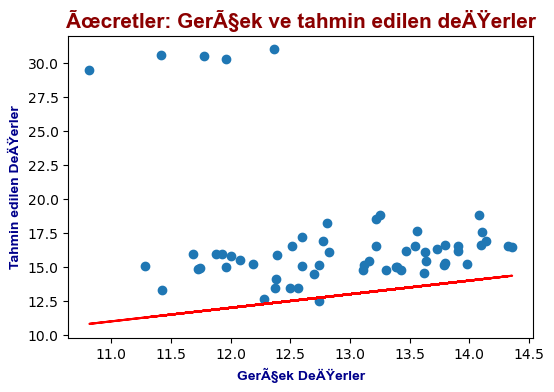

In [9]:
baslik_font = {'family': 'arial', 'color': 'darkred', 'weight': 'bold', 'size': 15}
eksen_font = {'family': 'arial', 'color': 'darkblue', 'weight': 'bold', 'size': 10}
plt.figure(dpi=100)
plt.scatter(results, result_prediction)
plt.plot(results, results, color="red")
plt.xlabel("GerÃ§ek DeÄŸerler", fontdict=eksen_font)
plt.ylabel("Tahmin edilen DeÄŸerler", fontdict=eksen_font)
plt.title("Ãœcretler: GerÃ§ek ve tahmin edilen deÄŸerler", fontdict=baslik_font)
plt.savefig("TSF.png", dpi=100)
plt.show()

In [10]:
TSF_data = {}
with open('TSF.png', mode='rb') as file:
    img = file.read()
TSF_data['img'] = base64.encodebytes(img).decode('utf-8')
print(json.dumps(TSF_data))

{"img": "iVBORw0KGgoAAAANSUhEUgAAAlgAAAGQCAYAAAByNR6YAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90\nbGliIHZlcnNpb24zLjMuNCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8QVMy6AAAACXBIWXMAAA9h\nAAAPYQGoP6dpAABWxUlEQVR4nO3deZgcVbnH8e9LhAQhM4CACZtENmUNKEsEWZQgyCagIooCIiqI\nKFiCqFxWiUApcAEXwMsqCCK7EtDLJhCWK4tERBBZQwJCZBIgCUve+8epZiqd3vv09DK/z/P0M9PV\nVadOdXVXvX3OW6fM3RERERGReBZpdwVEREREeo0CLBEREZHIFGCJiIiIRKYAS0RERCQyBVgiIiIi\nkSnAEhEREYlMAZaIiIhIZAqwRERERCJTgCUiIiISmQIsERERkcgUYImIiIhEpgBLREREJDIFWCIi\nIiKRKcASERERiUwBloiIiEhkCrBEREREIlOAJSIiIhKZAiwRERGRyBRgiYiIiESmAEtEREQkMgVY\nIiIiIpG9q90V6Dap2SLARcDuwDzgSeAFYGPg1sR9jzZWT7pIarYEcBWwFfAq8C9gJrAF8IvE/Ttt\nrJ6INCk12xc4L3s6LnF/KjXz7PmxifsxFZY9H9gHeDpxXzU12xq4JXt5m8T91hZUWSJSgFW/jYDP\nA88A84H3AesBM4DT21gv6T47ABOBJwjfxTWBJbPn57axXiIi0iQFWHVK3P8PsHbXQ7pf4n4F+iyJ\n9LKbgd2y/1/M/haeP1pl2f8GrgZez55PzS07NVL9pIXM3avPJQtJzb4EXJCb9KHE/f521WeopWY7\nAa8n7jfnpp1PaNIG2C1xv7oNVasoNXsPcACwKzAOeA/hAPZP4CbgjMT9+SGu038Bx2ZP3wRWTtxf\nqDD/+4HjCF2JyxNaUycDP0rc/91EPc6nw/dfJanZ+wj1Pq2JMs6nTe9